## Read CSV data into a pandas dataframe

The data used in this notebook is [Kaggle 48K movies](https://www.kaggle.com/datasets/yashgupta24/48000-movies-dataset) which contains a lot of metadata in addition to the raw review text.

Usually there is a data cleaning step.  Such as replace empty strings with "" or unusual and empty fields with median values.  Below, I'll just drop rows with null values.

In [1]:
# For colab install these libraries in this order:
# !pip install numpy pandas torch pymilvus langchain transformers sentence-transformers 

In [2]:
# Import common libraries.
import sys, os, time, pprint
import numpy as np
import pandas as pd

# Import custom functions for splitting and search.
sys.path.append("..")  # Adds higher directory to python modules path.
import milvus_utilities as _utils

In [3]:
# Import common libraries.
import sys, os, time, pprint
import numpy as np
import pandas as pd

# Import custom functions for splitting and search.
sys.path.append("..")  # Adds higher directory to python modules path.
import milvus_utilities as _utils

# Read CSV data.
df = pd.read_csv("data/original_data.csv")

# Concatenate 'Name', 'Keywords', and 'Description' into 'text' column
df['text'] = df['Name'] + ' ' + df['Description'] + ' ' + df['ReviewBody']
# drop rows without any text.
print(df.shape[0])
df = df.dropna(subset=['text'])
print(df.shape[0])

# Convert genres from string with commas in it to list of strings.
df['Genres'] = df['Genres'].str.split(',')
df['Genres'] = df['Genres'].apply(lambda d: d if isinstance(d, list) else [""])

# Convert actors from string with commas in it to list of strings.
df['Actors'] = df['Actors'].str.split(',')
df['Actors'] = df['Actors'].apply(lambda d: d if isinstance(d, list) else [""])

# Convert keywords from string with commas in it to list of strings.
df['Keywords'] = df['Keywords'].str.split(',')
df['Keywords'] = df['Keywords'].apply(lambda d: d if isinstance(d, list) else [""])

# Extract out just the year from the date.
def extract_year(movie_date):
    try:
        return int(movie_date.split('-')[0])
    except Exception:
        return -1  # return -1 instead of None
df['MovieYear'] = df.DatePublished.apply(extract_year)

# Convert 'Rating' to float.
df['RatingValue'] = pd.to_numeric(df['RatingValue'], errors='coerce')
df['RatingValue'] = df['RatingValue'].fillna(-1).astype('float32')

# Drop extra rating columns.
df.drop(columns=['RatingCount', 'BestRating', 'WorstRating',
                 'ReviewAurthor', 'ReviewDate',	'ReviewBody',	
                 'Description', 'duration', 'DatePublished'], inplace=True)

# Inspect text.
print(f"Example text length: {len(df.text[0])}")
pprint.pprint(f"Example text: {df.text[0]}")

# Shortcut the data for testing.
df = df.tail(600).copy()

print(df.dtypes)
display(df.head(2))

48513
45036
Example text length: 6556
('Example text: Sallie Gardner at a Gallop Sallie Gardner at a Gallop is a '
 'short starring Gilbert Domm and Sallie Gardner. The clip shows a jockey, '
 'Domm, riding a horse, Sally Gardner. The clip is not filmed but instead '
 'consists of 24 individual photographs shot in rapid... Sometimes ascribed as '
 '"The Father of the Motion Picture", Eadweard Muybridge undeniably '
 'accomplished exploiting and sometimes introducing a means of instantaneous '
 'and serial images to analyze and synthesize animal locomotion. In part, the '
 "reasons for and the claims made of his work support Virgilio Tosi's thesis "
 'that cinema was invented out of the needs of scientific research. '
 "Conversely, they're informed by Muybridge's background as an artistic "
 'location photographer and, as Phillip Prodger suggests, in book sales and '
 'more useful to art than to science, as Marta Braun has demonstrated (see '
 'sources at bottom). Additionally, Muybridg

,id,url,Name,PosterLink,Genres,Actors,Director,Keywords,RatingValue,text,MovieYear
47836,47836,https://www.imdb.com/title/tt5842890/,Jupiter holdja,https://m.media-amazon.com/images/M/MV5BNjY0Ym...,"[Drama, Fantasy, Mystery, Sci-Fi, Thriller]","[Merab Ninidze, Zsombor Jéger, György Cserhalm...",Kornél Mundruczó,"[rear nudity, bare chested male, levitation, d...",6.0,Jupiter holdja Jupiter holdja is a movie starr...,2017
47837,47837,https://www.imdb.com/title/tt5843670/,The Stakelander,https://m.media-amazon.com/images/M/MV5BMTY2Nz...,"[Action, Drama, Horror, Sci-Fi]","[Connor Paolo, Nick Damici, Laura Abramsen, A....","Dan Berk,Robert Olsen","[crying man, mother daughter relationship, cam...",5.3,The Stakelander The Stakelander is a movie sta...,2017


## Connect using Milvus Lite

Milvus Lite is a light Python server that can run locally.  It's ideal for getting started with Milvus, running on a laptop, in a Jupyter notebook, or on Colab. 

⛔️ Please note Milvus Lite is only meant for demos, not for production workloads.

- [github](https://github.com/milvus-io/milvus-lite)
- [documentation](https://milvus.io/docs/quickstart.md)

In [4]:
# STEP 1. CONNECT TO MILVUS LITE.

# !python -m pip install -U --no-cache-dir pymilvus
import pymilvus
print(f"pymilvus:{pymilvus.__version__}")

# Connect a client to the Milvus Lite server.
from pymilvus import MilvusClient
mc = MilvusClient("milvus_demo.db")

pymilvus:2.4.3


# Optional - Connect using Milvus standalone Docker

This section uses [Milvus standalone](https://milvus.io/docs/configure-docker.md) on Docker. <br>
>⛔️ Make sure you pip install the correct version of pymilvus and server yml file.  **Versions (major and minor) should all match**.

1. [Install Docker](https://docs.docker.com/get-docker/)
2. Start your Docker Desktop
3. Download the latest [docker-compose.yml](https://milvus.io/docs/install_standalone-docker.md#Download-the-YAML-file) (or run the wget command, replacing version to what you are using)
> wget https://github.com/milvus-io/milvus/releases/download/v2.4.0-rc.1/milvus-standalone-docker-compose.yml -O docker-compose.yml
4. From your terminal:  
   - cd into directory where you saved the .yml file (usualy same dir as this notebook)
   - docker compose up -d
   - verify (either in terminal or on Docker Desktop) the containers are running
5. From your code (see notebook code below):
   - Import milvus
   - Connect to the local milvus server

In [5]:
# # STEP 1. CONNECT TO MILVUS STANDALONE DOCKER.
# import pymilvus

# # print(f"Pymilvus: {pymilvus.__version__}") #2.4.3
# # !wget https://github.com/milvus-io/milvus/releases/download/v2.4.1/milvus-standalone-docker-compose.yml -O docker-compose.yml

# import pymilvus, time
# from pymilvus import (MilvusClient, utility, connections)
# print(f"Pymilvus: {pymilvus.__version__}")

# # Start the Milvus server.
# # !docker compose up -d

# # Connect to the local server.
# connection = connections.connect(
#   alias="default", 
#   host='localhost', # or '0.0.0.0' or 'localhost'
#   port='19530'
# )

# # Get server version.
# print(f"Milvus server: {utility.get_server_version()}")

## Load the Embedding Model checkpoint and use it to create vector embeddings
**Embedding model:**  We will use the open-source [sentence transformers](https://www.sbert.net/docs/pretrained_models.html) available on HuggingFace to encode the documentation text.  We will download the model from HuggingFace and run it locally. 

💡Tip:  A good way to choose a sentence transformer model is to check the [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).  Sort descending by column "Retrieval Average" and choose the best-performing small model.

Two model parameters of note below:
1. EMBEDDING_DIM refers to the dimensionality or length of the embedding vector. In this case, the embeddings generated for EACH token in the input text will have the SAME length = 1024. This size of embedding is often associated with BERT-based models, where the embeddings are used for downstream tasks such as classification, question answering, or text generation. <br><br>
2. MAX_SEQ_LENGTH is the maximum Context Length the encoder model can handle for input sequences. In this case, if sequences longer than 512 tokens are given to the model, everything longer will be (silently!) chopped off.  This is the reason why a chunking strategy is needed to segment input texts into chunks with lengths that will fit in the model's input.

In [6]:
# !python -m pip install -U sentence-transformers transformers

In [7]:
# STEP 2. DOWNLOAD AN OPEN SOURCE EMBEDDING MODEL.

# Import torch.
import torch
from sentence_transformers import SentenceTransformer

# Initialize torch settings
torch.backends.cudnn.deterministic = True
DEVICE = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

# Load the model from huggingface model hub.
model_name = "BAAI/bge-large-en-v1.5"
encoder = SentenceTransformer(model_name, device=DEVICE)

# Get the model parameters and save for later.
EMBEDDING_DIM = encoder.get_sentence_embedding_dimension()
MAX_SEQ_LENGTH_IN_TOKENS = encoder.get_max_seq_length() 
# Assume tokens are 3 characters long.
MAX_SEQ_LENGTH = MAX_SEQ_LENGTH_IN_TOKENS * 3
EOS_TOKEN_LENGTH = 1 * 3

# Use 512 sequence length.
MAX_SEQ_LENGTH = MAX_SEQ_LENGTH_IN_TOKENS
EOS_TOKEN_LENGTH = 1

# Inspect model parameters.
print(f"model_name: {model_name}")
print(f"EMBEDDING_DIM: {EMBEDDING_DIM}")
print(f"MAX_SEQ_LENGTH: {MAX_SEQ_LENGTH}")

/opt/miniconda3/envs/py311-unum/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model_name: BAAI/bge-large-en-v1.5
EMBEDDING_DIM: 1024
MAX_SEQ_LENGTH: 512


## Create a Milvus collection

You can think of a collection in Milvus like a "table" in SQL databases.  The **collection** will contain the 
- **Schema** (or [no-schema Milvus client](https://milvus.io/docs/using_milvusclient.md)).  
💡 You'll need the vector `EMBEDDING_DIM` parameter from your embedding model.
Typical values are:
   - 1024 for sbert embedding models
   - 1536 for ada-002 OpenAI embedding models
- **Vector index** for efficient vector search
- **Vector distance metric** for measuring nearest neighbor vectors
- **Consistency level**
In Milvus, transactional consistency is possible; however, according to the [CAP theorem](https://en.wikipedia.org/wiki/CAP_theorem), some latency must be sacrificed. 💡 Searching movie reviews is not mission-critical, so [`eventually`](https://milvus.io/docs/consistency.md) consistent is fine here.

## Add a Vector Index

The vector index determines the vector **search algorithm** used to find the closest vectors in your data to the query a user submits.  

Most vector indexes use different sets of parameters depending on whether the database is:
- **inserting vectors** (creation mode) - vs - 
- **searching vectors** (search mode) 

Scroll down the [docs page](https://milvus.io/docs/index.md) to see a table listing different vector indexes available on Milvus.  For example:
- FLAT - deterministic exhaustive search
- IVF_FLAT or IVF_SQ8 - Hash index (stochastic approximate search)
- HNSW - Graph index (stochastic approximate search)
- AUTOINDEX - Automatically determined based on OSS vs [Zilliz cloud](https://docs.zilliz.com/docs/autoindex-explained), type of GPU, size of data.

Besides a search algorithm, we also need to specify a **distance metric**, that is, a definition of what is considered "close" in vector space.  In the cell below, the [`HNSW`](https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md) search index is chosen.  Its possible distance metrics are one of:
- L2 - L2-norm
- IP - Dot-product
- COSINE - Angular distance

💡 Most use cases work better with normalized embeddings, in which case L2 is useless (every vector has length=1) and IP and COSINE are the same.  Only choose L2 if you plan to keep your embeddings unnormalized.

In [8]:
# STEP 3. CREATE A NO-SCHEMA MILVUS COLLECTION AND DEFINE THE DATABASE INDEX.

# Create a collection.
COLLECTION_NAME = "IMDB_metadata"

# Milvus Lite uses the MilvusClient object.
if mc.has_collection(COLLECTION_NAME):
    mc.drop_collection(COLLECTION_NAME)
    print(f"Successfully dropped collection: `{COLLECTION_NAME}`")

# # Check if collection already exists, if so drop it.
# has = utility.has_collection(COLLECTION_NAME)
# if has:
#     drop_result = utility.drop_collection(COLLECTION_NAME)
#     print(f"Successfully dropped collection: `{COLLECTION_NAME}`")
# # Use no-schema Milvus client uses flexible json key:value format.
# mc = MilvusClient(connections=connection)

# Create a collection with flexible schema and AUTOINDEX.
mc.create_collection(COLLECTION_NAME, 
                     EMBEDDING_DIM,
                     consistency_level="Eventually", 
                     auto_id=True,  
                     overwrite=True,
                    )
print(f"Successfully created collection: `{COLLECTION_NAME}`")

Successfully dropped collection: `IMDB_metadata`
Successfully created collection: `IMDB_metadata`


## Simple Chunking

Before embedding, it is necessary to decide your chunk strategy, chunk size, and chunk overlap.  This section uses:
- **Strategy** = Simple fixed chunk lengths.
- **Chunk size** = Use the embedding model's parameter `MAX_SEQ_LENGTH`
- **Overlap** = Rule-of-thumb 10-15%
- **Function** = 
  - Langchain's `RecursiveCharacterTextSplitter` to split up long reviews recursively.

## Insert data into Milvus

For each original text chunk, we'll write the quadruplet (`vector, text, source, h1, h2`) into the database.

<div>
<img src="../../images/db_insert.png" width="80%"/>
</div>

**The Milvus Client wrapper can only handle loading data from a list of dictionaries.**

Otherwise, in general, Milvus supports loading data from:
- pandas dataframes 
- list of dictionaries

Below, we use the embedding model provided by HuggingFace, download its checkpoint, and run it locally as the encoder. 

In [9]:
# Define functions for chunking and embedding.
from langchain.text_splitter import RecursiveCharacterTextSplitter

def recursive_splitter_wrapper(text, chunk_size):

    # Default chunk overlap is 10% chunk_size.
    chunk_overlap = np.round(chunk_size * 0.10, 0)

    # Use langchain's convenient recursive chunking method.
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        separators=["\n", "\n\n", "<br /><br />"],
    )
    chunks = text_splitter.split_text(text)

    return chunks

# Use recursive splitter to chunk text.
def imdb_chunk_text(df_batch, chunk_size):

    batch = df_batch.copy()
    print(f"original shape: {batch.shape}")
    
    start_time = time.time()

    # 1. Chunk the text review into chunk_size.
    batch['chunk'] = batch['text'].apply(recursive_splitter_wrapper, chunk_size=chunk_size)
    # Explode the 'chunk' column to create new rows for each chunk.
    batch = batch.explode('chunk', ignore_index=True)
    print(f"new shape: {batch.shape}")

    # 2. Add embeddings as new column in df.
    embeddings = torch.tensor(encoder.encode(batch['chunk']))
    # Normalize the embeddings.
    embeddings = np.array(embeddings / np.linalg.norm(embeddings))

    # 3. Convert embeddings to list of `numpy.ndarray`, each containing `numpy.float32` numbers.
    converted_values = list(map(np.float32, embeddings))
    batch['vector'] = converted_values

    end_time = time.time()
    print(f"Chunking + embedding time for {batch.shape[0]} docs: {end_time - start_time} sec")
    # Inspect the batch of data.
    # assert len(batch.chunk[0]) <= MAX_SEQ_LENGTH-1
    assert len(batch.vector[0]) == EMBEDDING_DIM
    # print(f"type embeddings: {type(batch.vector)} of {type(batch.vector[0])}")
    # print(f"of numbers: {type(batch.vector[0][0])}")

    return batch

In [10]:
## Chunk and Embed Text Data

# Use the embedding model parameters.
# chunk_size = MAX_SEQ_LENGTH - HF_EOS_TOKEN_LENGTH
chunk_size = 512
chunk_overlap = np.round(chunk_size * 0.10, 0)
BATCH_SIZE = 200
print(f"chunk size: {chunk_size}")

for i in range(0, len(df), BATCH_SIZE):

    # STEP 5. CHUNK AND EMBED TEXT DATA.
    batch = imdb_chunk_text(df.iloc[i:i+BATCH_SIZE], chunk_size)
    # display(batch.head(2))

    # Drop the original text column, keep the new 'chunk' column.
    batch.drop(columns=['id','text'], axis=1, inplace=True)

    # STEP 6. INSERT CHUNK LIST INTO MILVUS OR ZILLIZ.
    # Convert the DataFrame to a list of dictionaries
    dict_list = batch.to_dict(orient='records')

    # Insert data into the Milvus collection.
    print("Start inserting entities")
    start_time = time.time()
    insert_result = mc.insert(
        COLLECTION_NAME,
        data=dict_list,
        progress_bar=True)
    end_time = time.time()
    print(f"Milvus Client insert time for {batch.shape[0]} vectors: {end_time - start_time} seconds")
    print()

chunk size: 512
original shape: (200, 11)
new shape: (443, 12)
Chunking + embedding time for 443 docs: 36.468486070632935 sec
Start inserting entities
Milvus Client insert time for 443 vectors: 0.1802201271057129 seconds

original shape: (200, 11)
new shape: (394, 12)
Chunking + embedding time for 394 docs: 33.942102909088135 sec
Start inserting entities
Milvus Client insert time for 394 vectors: 0.11721491813659668 seconds

original shape: (200, 11)
new shape: (433, 12)
Chunking + embedding time for 433 docs: 35.6629958152771 sec
Start inserting entities
Milvus Client insert time for 433 vectors: 0.14162302017211914 seconds



In [11]:
# Count rows.
start_time = time.time()
res = mc.query( collection_name=COLLECTION_NAME, 
               filter="", 
               output_fields = ["count(*)"], )
pprint.pprint(res)
end_time = time.time()
print(f"timing: {round(end_time - start_time, 4)} seconds")

data: ["{'count(*)': 1270}"] , extra_info: {'cost': 0}
timing: 0.0021 seconds


In [12]:
# TODO - Uncomment to inspect the first chunk and its metadata.
print(len(dict_list))
print(type(dict_list[0]), len(dict_list[0]))
pprint.pprint(dict_list[0])

433
<class 'dict'> 11
{'Actors': ['Gay Talese', 'Gerald Foos', 'Nan Talese', 'Susan Morrison'],
 'Director': 'Myles Kane,Josh Koury',
 'Genres': ['Documentary'],
 'Keywords': ['male frontal nudity', 'male nudity', 'voyeur'],
 'MovieYear': 2017,
 'Name': 'Voyeur',
 'PosterLink': 'https://m.media-amazon.com/images/M/MV5BODE2OTg1NDQ0M15BMl5BanBnXkFtZTgwMjg0NTAxNDM@._V1_.jpg',
 'RatingValue': 6.199999809265137,
 'chunk': 'Voyeur Voyeur is a movie starring Gay Talese, Gerald Foos, and Nan '
          'Talese. Journalism icon Gay Talese reports on Gerald Foos, the '
          'owner of a Colorado motel, who allegedly secretly watched his '
          'guests with the aid of specially designed... "Voyeur," a '
          'documentary purportedly about an infamous voyeur, should really be '
          'titled "Pseudo-Journalist," since what it really demonstrates is '
          'what a terrible writer Gay Talese is. It\'s not "true crime," since '
          'so many of the claims in it are debata

In [13]:
# Define metadata fields you can filter on.
OUTPUT_FIELDS = list(dict_list[0].keys())
# drop vector field
OUTPUT_FIELDS.remove('vector')
OUTPUT_FIELDS.insert(0, 'id')
OUTPUT_FIELDS

['id',
 'url',
 'Name',
 'PosterLink',
 'Genres',
 'Actors',
 'Director',
 'Keywords',
 'RatingValue',
 'MovieYear',
 'chunk']

In [14]:
# List distinct genres
GENRES = list(set([genre for genres in df['Genres'] for genre in genres]))
GENRES

['',
 'Comedy',
 'Sci-Fi',
 'History',
 'Music',
 'Drama',
 'Horror',
 'War',
 'Musical',
 'Documentary',
 'Family',
 'Biography',
 'Romance',
 'Thriller',
 'Short',
 'Fantasy',
 'News',
 'Mystery',
 'Adventure',
 'Animation',
 'Action',
 'Western',
 'Crime',
 'Sport']

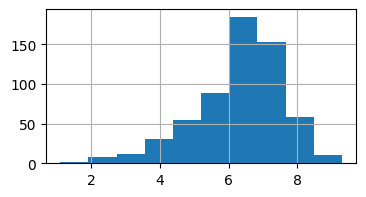

In [15]:
# Plot histogram of rating values.
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 2))
df['RatingValue'].hist();
# Scale of 1-10.  Popular movies are rated >= 7.

## Ask a question about your data

So far in this demo notebook: 
1. Your custom data has been mapped into a vector embedding space
2. Those vector embeddings have been saved into a vector database

Next, you can ask a question about your custom data!

💡 In LLM vocabulary:
> **Query** is the generic term for user questions.  
A query is a list of multiple individual questions, up to maybe 1000 different questions!

> **Question** usually refers to a single user question.  
In our example below, the user question is "What is AUTOINDEX in Milvus Client?"

> **Semantic Search** = very fast search of the entire knowledge base to find the `TOP_K` documentation chunks with the closest embeddings to the user's query.

💡 The same model should always be used for consistency for all the embeddings data and the query.

In [16]:
# Define a sample question about your data.

# This question for the JSON dataset.
SAMPLE_QUESTION = "Dystopia science fiction with a robot."

## Execute a vector search

Search Milvus using [PyMilvus API](https://milvus.io/docs/search.md).

💡 By their nature, vector searches are "semantic" searches.  For example, if you were to search for "leaky faucet": 
> **Traditional Key-word Search** - either or both words "leaky", "faucet" would have to match some text in order to return a web page or link text to the document.

> **Semantic search** - results containing words "drippy" "taps" would be returned as well because these words mean the same thing even though they are different words.

In [17]:
# Define a convenience function for searching.
def mc_run_search(question, filter_expression, top_k):
    # Embed the question using the same encoder.
    query_embeddings = _utils.embed_query(encoder, [question])

    # Run semantic vector search using your query and the vector database.
    results = mc.search(
        COLLECTION_NAME,
        data=query_embeddings, 
        # search_params=SEARCH_PARAMS,
        output_fields=OUTPUT_FIELDS, 
        # Milvus can utilize metadata in boolean expressions to filter search.
        filter=filter_expression,
        # expr=filter_expression,
        limit=top_k,
        consistency_level="Eventually"
    )

    # Assemble retrieved context and context metadata.
    # The search result is in the variable `results[0]`, which is type 
    # 'pymilvus.orm.search.SearchResult'. 
    METADATA_FIELDS = [f for f in OUTPUT_FIELDS if f != 'chunk']
    formatted_results, context, context_metadata = _utils.client_assemble_retrieved_context(
        results, metadata_fields=METADATA_FIELDS, num_shot_answers=top_k)
    
    return formatted_results, context, context_metadata

In [25]:
# STEP 7. RETRIEVE ANSWERS FROM YOUR DOCUMENTS STORED IN MILVUS OR ZILLIZ.

TOP_K = 10
# Metadata filters for CSV dataset.
expression = ""
expression='RatingValue >= 7'
# Infix string match.
expression=expression + ' && (Name like "%Panther%")'
# Exact array element with prefix or infix match.
# expression=expression + ' && (Genres[0] like "Sci-Fi%" || Genres[1] like "%Sci-Fi%" || Genres[2] == "Sci-Fi")'
# String array contains a value, not working.
# https://milvus.io/docs/array_data_type.md#Advanced-filtering
# expression=expression + ' && ARRAY_CONTAINS_ANY(Genres, ["%Sci-Fi%"])'
print(f"filter: {expression}")

start_time = time.time()
formatted_results, contexts, context_metadata = \
    mc_run_search(SAMPLE_QUESTION, expression, TOP_K)
elapsed_time = time.time() - start_time
print(f"Milvus Client search time for {len(dict_list)} vectors: {elapsed_time} seconds")

# Inspect search result.
print(f"type: {type(formatted_results)}, count: {len(formatted_results)}")

filter: RatingValue >= 7 && (Name like "%Panther%")
Milvus Client search time for 433 vectors: 0.20736312866210938 seconds
type: <class 'list'>, count: 2


In [26]:
# Display poster link.
from IPython.display import Image
from IPython.display import display

# Loop through recommended movies, display poster, print metadata.
seen_movies = []
for i in range(len(contexts)):
    print(f"Retrieved result #{i+1}")
    print(f"distance = {formatted_results[i][0]}")
    # Get the movie_index
    movie_index = context_metadata[i]['id']
    movie_name = context_metadata[i]['Name']
    print(f"movie_index: {movie_index}")

    # Don't display the same movie_index twice.
    if movie_name in seen_movies:
        continue
    else:
        seen_movies.append(movie_name)
        # Display the first poster link as a rendered image
        x = Image(url = context_metadata[i]['PosterLink'], width=150, height=200) 
        display(x)

        # Print the rest of the movie info.
        pprint.pprint(f"chunk: {contexts[i]}")
        # print metadata except the movie_index and poster link.
        for key, value in context_metadata[i].items():
            if ((key != 'PosterLink') and (key != 'movie_index')):
                print(f"{key}: {value}")
        print()

Retrieved result #1
distance = 0.45058321952819824
movie_index: 450537193043396268


('chunk: It has no special story, and the plot is totally predictable. Colors '
 'and visuals are the only gorgeous parts of this film. I felt cheated after '
 'how amazingly Black Panther was shown in Civil War.\n'
 '\n'
 'It has been released in 3D but there are merely a few shots that felt good '
 'in 3D.\n'
 '\n'
 'Overall acting is okay; no actor leaves their mark on your mind. And as '
 'always, this Marvel movie too suffers with the villain deficiency syndrome.\n'
 '\n'
 "6 out of 10 from me, that's it.")
id: 450537193043396268
url: https://www.imdb.com/title/tt1825683/
Name: Black Panther
Genres: ['Action', 'Adventure', 'Sci-Fi']
Actors: ['Chadwick Boseman', 'Michael B. Jordan', "Lupita Nyong'o", 'Danai Gurira']
Director: Ryan Coogler
Keywords: ['marvel cinematic universe', 'marvel comics', 'based on comic book', 'king', 'african king']
RatingValue: 7.300000190734863
MovieYear: 2018

Retrieved result #2
distance = 0.3965144753456116
movie_index: 450537193043396267


In [20]:
# # Drop the collection.
# mc.drop_collection(COLLECTION_NAME)
# print(f"Successfully dropped collection: `{COLLECTION_NAME}`")

In [21]:
# Props to Sebastian Raschka for this handy watermark.
# !pip install watermark

%load_ext watermark
%watermark -a 'Christy Bergman' -v -p torch,transformers,sentence_transformers,pymilvus,langchain --conda

Author: Christy Bergman

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

torch                : 2.3.0
transformers         : 4.41.2
sentence_transformers: 2.6.1
pymilvus             : 2.4.3
langchain            : 0.2.2

conda environment: py311-unum

